## Long Short-Term Memory (LSTM):
### It is a type of recurrent neural network (RNN) designed to handle sequential data and capture long-term dependencies. LSTMs are equipped with memory cells and gating mechanisms that regulate the flow of information, allowing them to retain or forget information over time. This architecture addresses the vanishing gradient problem commonly faced by standard RNNs. LSTMs are widely used in various applications, including natural language processing, time series forecasting, and speech recognition, due to their ability to learn patterns and dependencies in complex sequences, making them effective for tasks requiring context and temporal dynamics.

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
#Convert date coulmns to specific format
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
#Read csv file
df = pd.read_csv(r'BrentOilPrices1.csv',parse_dates=['Date'], date_parser=dateparse)
print("jos")
#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
#df=df.loc[datetime.date(year=2000,month=1,day=1):]
df=df.loc[datetime.strptime('2000-01-01',"%Y-%d-%m"):]

jos


In [3]:

# Print some data rows.
df.head()

,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77


### DataFrame Info Function

The following function `DfInfo` provides a summary of a given DataFrame, including the column types, the number of null values, and the percentage of null values


In [4]:
#Read dataframe info
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [5]:
df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-20', '2020-04-21'],
              dtype='datetime64[ns]', name='Date', length=5160, freq=None)

### Resampling Data to Monthly Frequency

The following line of code resamples the `Price` column in a DataFrame to a monthly frequency and calculates the average price for each month:



In [5]:
y = df['Price'].resample('MS').mean()

## Plotting the 'Price' column

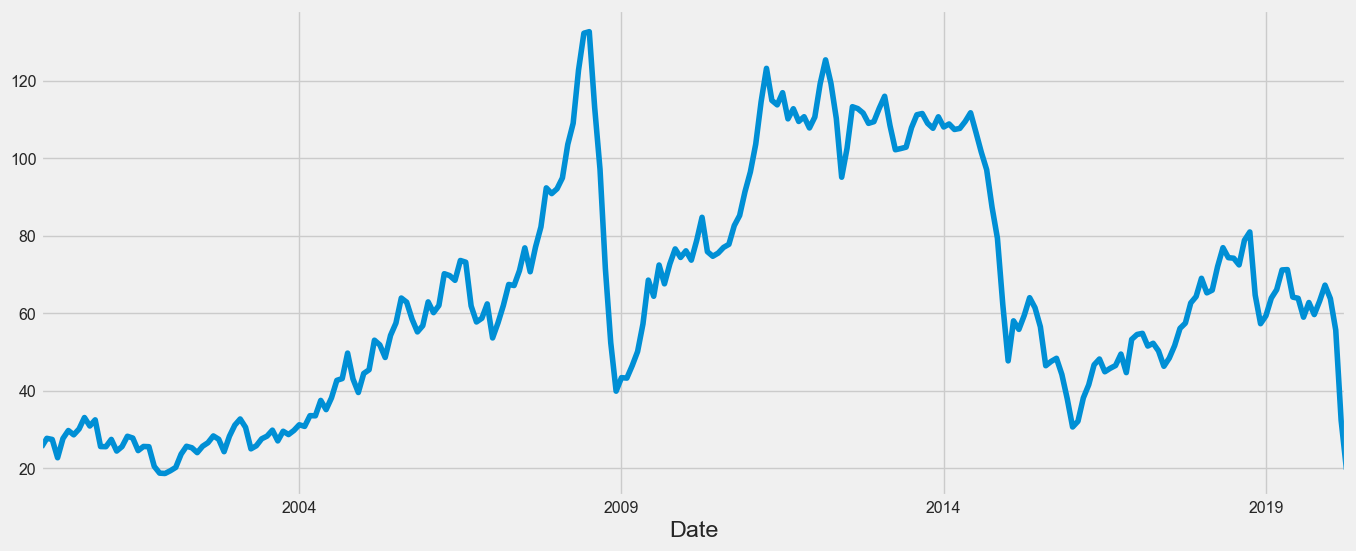

In [6]:
y.plot(figsize=(15, 6))
plt.show()

### Seasonal Decomposition of Time Series

The following code performs seasonal decomposition of a time series into its components: trend, seasonal, and residual.



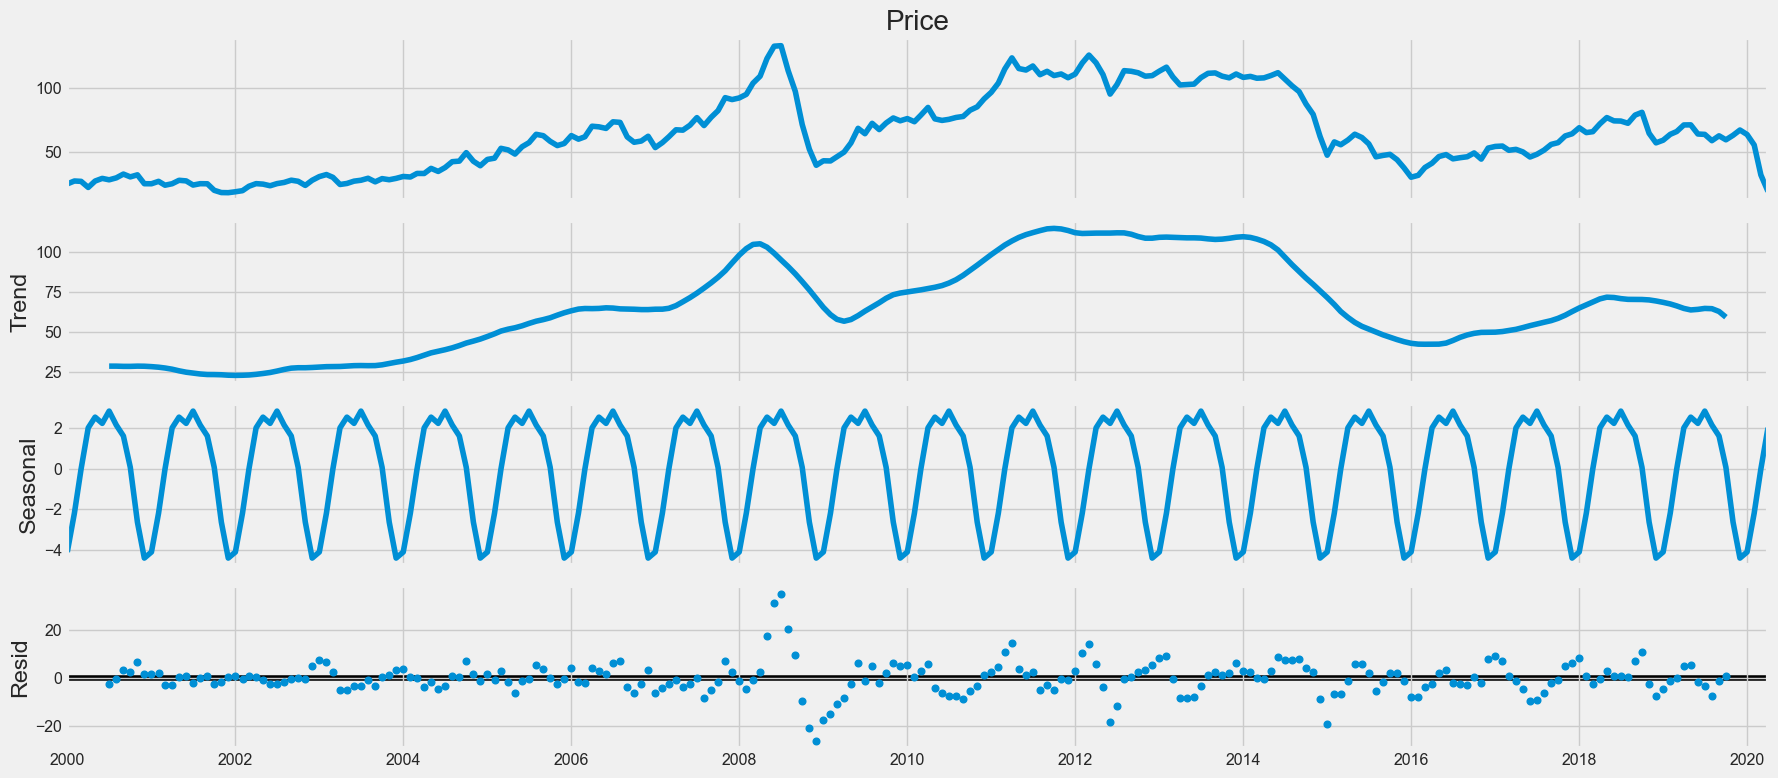

In [7]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## from the graph bwe can see that here , trend , seasonal components are present . 

### Normalizing the Dataset Using MinMaxScaler

In data preprocessing, it's common to normalize the features before applying machine learning algorithms. The following code snippet demonstrates how to normalize a dataset using `MinMaxScaler` from `sklearn.preprocessing`. This scales the values in the dataset so that they lie within the specified range, typically between 0 and 1.


In [8]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

### Splitting the Dataset into Training and Testing Sets

Before applying machine learning models, it's essential to divide the dataset into training and testing sets. This allows the model to be trained on one portion of the data (training set) and evaluated on another portion (testing set). The following code splits the dataset into 70% training and 30% testing sets.



In [9]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

### Converting an Array of Values into a Dataset Matrix

To prepare the data for time series forecasting, a dataset matrix can be created where each input `X` consists of a certain number of previous time steps (`look_back`), and the corresponding output `Y` is the next value in the sequence. The following function transforms a dataset into such a format.



In [10]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

### Reshaping Data into X=t and Y=t+1

To prepare the data for a sequence-to-sequence forecasting model like an LSTM (Long Short-Term Memory) network, the data needs to be reshaped into sequences of `X=t` (inputs) and `Y=t+1` (outputs). Each sequence of past observations (e.g., `t` time steps) is used to predict the next value in the time series (`t+1`).

The following code achieves this by:
- Splitting the data into training and testing sets.
- Using the `create_data_set` function to generate the sequences of inputs (`X`) and corresponding outputs (`Y`).
- Reshaping the inputs to fit the 3D shape required by LSTMs (samples, timesteps, features).


In [11]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Creating and Fitting an LSTM Network Regressor

In this section, we  create and train a Long Short-Term Memory (LSTM) network for time series forecasting. The LSTM model is well-suited for learning patterns in sequential data. 


In [12]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 5, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 5, return_sequences = True))
regressor.add(Dropout(0.1))
# # following two added by JJ
# regressor.add(LSTM(units = 60, return_sequences = True))
# regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 5))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.0124 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0442 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0329 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.0124 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0048 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0035 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.0032 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0029 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0027 - val_loss: 0.0043 - learning_rate:

### Making Predictions with the Trained LSTM Network

After training the LSTM network, we can use it to make predictions on both the training and test datasets. This allows us to evaluate the model's performance and analyze the results.


In [13]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


### Inverting Predictions

After training the LSTM model and making predictions on the training and test datasets, the next step is to revert the scaled predictions back to their original value range. This is particularly important if we applied normalization (such as Min-Max scaling) to your data before training. Below is the process for inverting both the predicted values and the true values.


In [14]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

### Model Performance Evaluation

After training the LSTM model, it's important to evaluate its performance using appropriate metrics. Here, we use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to assess the accuracy of the predictions on both the training and test datasets. Additionally, we visualize the loss during training to monitor the model's performance over epochs.

Train Mean Absolute Error: 8.63926199427518
Train Root Mean Squared Error: 10.025784615489563
Test Mean Absolute Error: 9.301374057931994
Test Root Mean Squared Error: 10.025318171672788


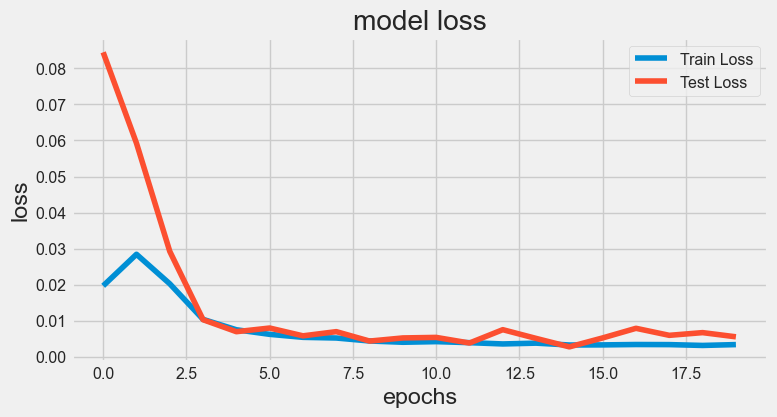

In [15]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

### Interpretation of Model Loss Plot

1. **Training Loss (Blue Line):**
   - Decreases significantly in the initial epochs, indicating effective learning.
   - Stabilizes at a low value after around 10 epochs, suggesting optimal learning.

2. **Test Loss (Red Line):**
   - Decreases but remains higher than training loss, indicating potential overfitting.
   - The gap suggests the model is tailored to training data but less so to unseen data.

3. **Stability:**
   - Both losses stabilize towards the end of training, indicating learned patterns.
   - Continuous monitoring is needed to assess if further training or adjustments are required.


### Actual vs. Predicted Values Comparison

To evaluate the performance of our LSTM model visually, we can compare the actual prices against the predicted prices. This allows us to assess how well the model captures the underlying trends in the data.

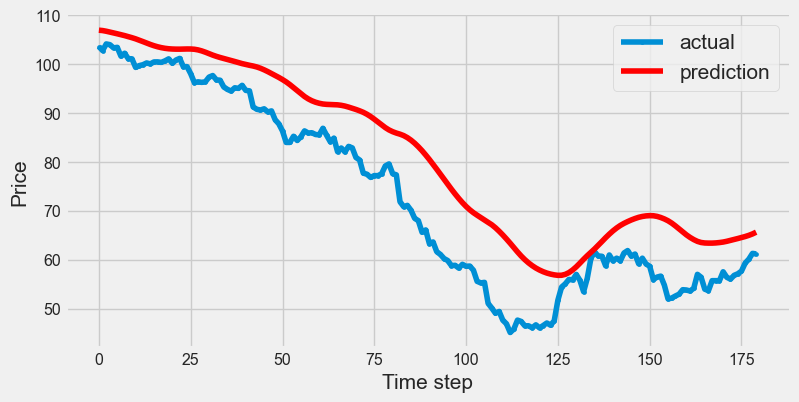

In [16]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

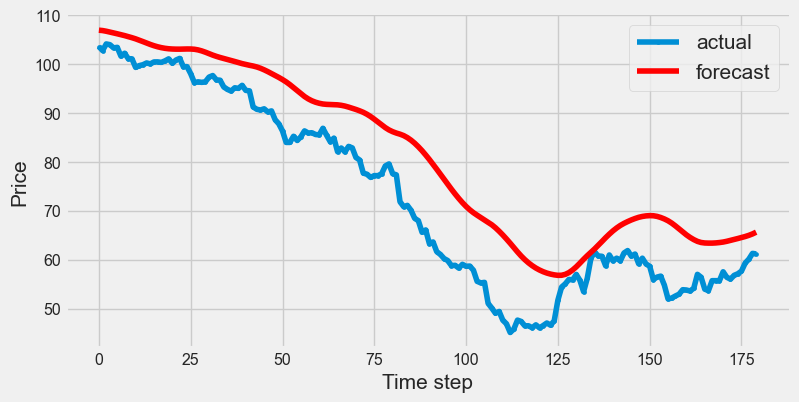

Forecasted values for the first 180 time steps:
[106.98494  106.90821  106.76974  106.60293  106.42807  106.24823
 106.0717   105.877    105.67208  105.448906 105.21175  104.9416
 104.64805  104.34894  104.06545  103.80755  103.588036 103.41164
 103.2759   103.18163  103.13151  103.10553  103.10294  103.12517
 103.139854 103.13427  103.08235  102.95084  102.744286 102.479485
 102.180786 101.88722  101.62664  101.3968   101.196266 101.00105
 100.79605  100.57538  100.35556  100.146385  99.96581   99.803314
  99.653595  99.4586    99.196655  98.87244   98.509224  98.11962
  97.72602   97.315346  96.8792    96.40162   95.85052   95.236046
  94.608574  93.989746  93.41539   92.92921   92.53943   92.244934
  92.03056   91.88078   91.80653   91.7762    91.74504   91.70761
  91.611244  91.4582    91.24625   91.00875   90.76361   90.488815
  90.176025  89.7842    89.31202   88.768974  88.18863   87.603355
  87.04833   86.576324  86.21617   85.934425  85.70645   85.41449
  85.00321   84.47932  

In [19]:
# Compare Actual vs. Forecast
aa = [x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="forecast")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Print forecasted values
print("Forecasted values for the first 180 time steps:")
print(test_predict[:,0][:180])


### Interpretation of Actual vs. Forecasted Prices Plot

1. **Trend Alignment:** Both actual prices (blue line) and predicted prices (red line) show a downward trend, indicating that the model captures the overall direction of price movement.

2. **Initial Accuracy:** In the early time steps (0 to 50), predictions closely follow actual values, showing strong initial performance.

3. **Divergence:** From about time steps 100 to 130, the predicted prices diverge significantly from actual prices, indicating the model struggles during this period.

4. **Subsequent Recovery:** After the divergence, the model's predictions improve and align more closely with actual prices towards the end of the time series (140 to 175).

5. **Smoothing Effect:** The predictions are smoother than actual prices, suggesting the model averages out noise, which may result in missed sudden changes.


## The ARIMA model is the best among the three, as it has the lowest Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). Lower error metrics indicate that ARIMA provides more accurate predictions compared to Exponential Smoothing and LSTM for this dataset.